# Mass evacuation gymnasium tutorial

This tutorial demonstrates how to use the gym_mass_evacuation python package to study a multi-domain response to a mass evacuation. 

In [1]:
# import packages
import gymnasium as gym
import numpy as np
import pandas as pd
import copy
import math
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

/var/folders/ct/wc1j0dpn1wngl49q5ctqv3g80000gn/T/ipykernel_30319/3277356308.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Next, import two modules from the gym_mass_evacuation package. The first module, mass_evacuation, contains the mass evacuation gymnasium environment. The second module, mass_evacuation_policy, contians a set of benchmark policy function approximations as described in Rempel (2024).

In [2]:
from gym_mass_evacuation.mass_evacuation import MassEvacuation
from gym_mass_evacuation.mass_evacuation_policy import MassEvacuationPolicy

## Setting up the initial state, environment, and decision policies

In [3]:
# set the environment's seed and initial state that was used in Rempel (2024)
# Set the seed that was used in Rempel (2024)
rempel_2024_seed = 20180529

# Set the initial state
rempel_2024_initial_state = {
            'm_e' : {'white' : 120, 'green' : 48, 'yellow' : 8, 'red' : 1.5},
            'm_s' : {'green' : 48, 'yellow' : 72, 'red' : 120},
            'c_h' : 10,
            'c_s' : 50,
            'delta_h' : {'white' : 1, 'green' : 1, 'yellow' : 3, 'red' : 3},
            'delta_s' : {'white' : 1, 'green' : 1, 'yellow' : 3, 'red' : 3},
            'eta_h' : 3,
            'eta_sl' : 1,
            'eta_su' : 24,
            'tau_k' : 0,
            'e_k' : 0,
            'rho_e_k' : {'white' : 0, 'green' : 475, 'yellow' : 20, 'red' : 5},
            'rho_s_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
            'initial_helo_arrival' : [48],
            'initial_ship_arrival' : [0]
        }

In [4]:
# create the environment and policy objects
env = MassEvacuation(initial_state = rempel_2024_initial_state, \
                     seed = rempel_2024_seed,
                     default_rng = False)

policy = MassEvacuationPolicy()

In [5]:
# define the default action
action = {'x_hl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
          'x_sl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
          'x_su_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0}
         }

num_trials = 30
ship_arrival_time = np.arange(0, 180, 12)
objective_value = np.zeros([len(ship_arrival_time), num_trials])

for idx, ship_arrival in enumerate(ship_arrival_time):

    env.initial_state['initial_ship_arrival'] = [ship_arrival]
    for t in tqdm(range(num_trials)):
        done = False
    
        while not done:
    
            # The action space in this is defined by three types of actions that can be taken that depend on the event that is occuring.
            # The actions are:
            # - load the helicopter with {white, green, yellow, red}
            # - load the ship with {whtie, green, yellow, red}
            # - unload the ship with {white, green, yellow, red}
    
            action = {'x_hl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
                      'x_sl_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0},
                      'x_su_k' : {'white' : 0, 'green' : 0, 'yellow' : 0, 'red' : 0}
                      }
    
            if (env.state['e_k']) == 1:
    
                # load the helicopter
                params = {}
                params['total_capacity'] = env.initial_state['c_h']
                params['individual_capacity'] = env.initial_state['delta_h']
                action['x_hl_k'] = policy.green_first_loading_policy(state = env.state, \
                                                                     params = params)
            elif (env.state['e_k'] == 2):
    
                # load the ship
                params = {}
                params['total_capacity'] = env.initial_state['c_s']
                params['individual_capacity'] = env.initial_state['delta_s']
                action['x_sl_k'] = policy.green_first_loading_policy(state = env.state, \
                                                                     params = params)
            elif (env.state['e_k'] == 3):
    
                # unload the ship
                action['x_su_k'] = policy.white_unloading_policy(state = env.state) 
    
            observation, reward, terminated, truncated, info = env.step(action)
            env.state = observation
    
            objective_value[idx, t] += reward
            done = terminated or truncated
    
        options = {}
        options['single_scenario'] = True
        env.reset(options = options)

100%|██████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.93it/s]


In [6]:
print('Expected number of lives saved when the ship arrives at t = 0 : ', objective_value[0, :].mean())

Expected number of lives saved when the ship arrives at t = 0 :  167.46666666666667


/Users/mark/anaconda3/envs/mass_evacuation/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mark/anaconda3/envs/mass_evacuation/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


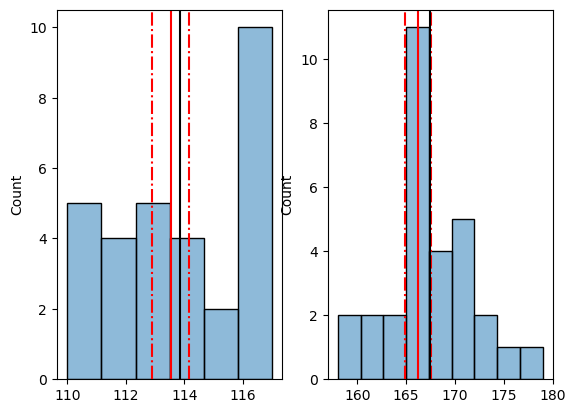

In [18]:
fig, ax = plt.subplots(1,2)
sns.histplot(objective_value[len(ship_arrival_time) - 1, :], alpha = 0.5, ax = ax[0])
ax[0].axvline(113.53, 0, 1, color = 'red')
ax[0].axvline(113.53 + 0.64, 0, 1, color = 'red', linestyle = '-.')
ax[0].axvline(113.53 - 0.64, 0, 1, color = 'red', linestyle = '-.')
ax[0].axvline(objective_value[len(ship_arrival_time) - 1, :].mean(), 0, 1, color = 'black')


sns.histplot(objective_value[0, :], alpha = 0.5, ax = ax[1])
ax[1].axvline(166.2, 0, 1, color = 'red')
ax[1].axvline(166.2 + 1.33, 0, 1, color = 'red', linestyle = '-.')
ax[1].axvline(166.2 - 1.33, 0, 1, color = 'red', linestyle = '-.')
ax[1].axvline(objective_value[0, :].mean(), 0, 1, color = 'black')

In [21]:
# create the environment and policy objects
env = MassEvacuation(initial_state = rempel_2024_initial_state, \
                     seed = rempel_2024_seed,
                     default_rng = False)

print(env.state)

# sample an action
action_sample = env.action_space.sample()

# convert the sampled action into an action that can be used by the environment
action = {'x_hl_k' : {'white' : action_sample['x_hl_k'][0,0], 
                      'green' : action_sample['x_hl_k'][0,1], 
                      'yellow' : action_sample['x_hl_k'][0,2], 
                      'red' : action_sample['x_hl_k'][0,3]}, \
          'x_sl_k' : {'white' : action_sample['x_sl_k'][0,0], 
                      'green' : action_sample['x_sl_k'][0,1], 
                      'yellow' : action_sample['x_sl_k'][0,2],
                      'red' : action_sample['x_sl_k'][0,3]},
          'x_su_k' : {'white' : action_sample['x_su_k'][0,0], 
                      'green' : action_sample['x_su_k'][0,1], 
                      'yellow' : action_sample['x_su_k'][0,2], 
                      'red' : action_sample['x_su_k'][0,3]}
                  }

print(action)

# submit the action to the environment and check what is returned
observation, reward, terminated, truncated, info = env.step(action)
print(observation)

{'tau_k': 0, 'e_k': 0, 'rho_e_k': {'white': 0, 'green': 475, 'yellow': 20, 'red': 5}, 'rho_s_k': {'white': 0, 'green': 0, 'yellow': 0, 'red': 0}}
{'x_hl_k': {'white': 6, 'green': 3, 'yellow': 10, 'red': 8}, 'x_sl_k': {'white': 12, 'green': 13, 'yellow': 20, 'red': 32}, 'x_su_k': {'white': 31, 'green': 17, 'yellow': 40, 'red': 48}}
{'tau_k': 48, 'rho_e_k': {'white': 0, 'green': 148, 'yellow': 37, 'red': 7}, 'rho_s_k': {'white': 0, 'green': 0, 'yellow': 0, 'red': 0}, 'e_k': 1}


array([[1, 2, 7, 3]], dtype=int32)

In [41]:
objective_value[10,:].mean()

123.53333333333333